# 0. Data Importing from kaggle

In [1]:
import os
from tqdm.notebook import tqdm
for dirname, _, filenames in tqdm(os.walk('/kaggle/input')):
    for filename in filenames:
        os.path.join(dirname, filename)
#         print(os.path.join(dirname, filename))

0it [00:00, ?it/s]

# Limiting GPU usage

In [2]:
# limit memory to prevent data leak
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    
    del logical_gpus,gpus
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


# 1. Importing modules

In [3]:
import numpy as np
import pandas as pd
import json
import gc
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import os
train_files = glob("../input/quickdraw-doodle-recognition/train_simplified/*.csv")

# calculating data size per category
rows = 200000
# rows = 10000
rows = rows - (rows % 340)
cat_size = rows // 340
print(cat_size)
gc.collect()

588


56

# 2. Image Preprocessing 
1. converting data in text json to an image 
2. normalizing the image size
3. normalizing the image pixels


In [4]:
from PIL import Image, ImageDraw
from dask import bag
def drawStrokes(matrixOfStrokes):
    image = Image.new("RGB", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in json.loads(matrixOfStrokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    return np.array(image.resize((32,32)))/255.

In [5]:
from tqdm.notebook import tqdm
X = np.zeros((rows,32,32,3))
categories = pd.Series([None] * rows)
i = 0
for f in tqdm(train_files):
    for df in pd.read_csv(f, index_col="key_id", chunksize=1000, nrows=cat_size):
        df = df.drop(['countrycode','timestamp','recognized'],axis=1)
        imagebag = bag.from_sequence(df.drawing.values).map(drawStrokes)
        imagebag = np.array(imagebag.compute())
        categories[i:(i + imagebag.shape[0])] = df["word"].replace("\s+", "_", regex=True)
        X[i:(i + imagebag.shape[0])] = imagebag
        i += imagebag.shape[0]


  0%|          | 0/340 [00:00<?, ?it/s]

In [6]:
gc.collect()

39

In [7]:
categories.value_counts()

traffic_light    588
umbrella         588
house            588
trombone         588
paper_clip       588
                ... 
rain             588
rabbit           588
lantern          588
toaster          588
fish             588
Length: 340, dtype: int64

# 3. Train Test split

In [8]:

from sklearn.model_selection import train_test_split
Y = pd.get_dummies(categories)
tr_x,tst_x,tr_Y,tst_Y = train_test_split(X, Y, test_size=0.25,random_state=24,stratify=Y)


In [9]:
itr = 0
for df in tr_Y:
    print(f"{df} : {tr_Y[df].value_counts()[1]}")
    if itr == 5:
        break
    else:
        itr+= 1

The_Eiffel_Tower : 441
The_Great_Wall_of_China : 441
The_Mona_Lisa : 441
airplane : 441
alarm_clock : 441
ambulance : 441


In [10]:
itr = 0
for df in tst_Y:
    try:
        print(f"{df} : {tst_Y[df].value_counts()[1]}")
    except:
        print(f"{df} : 0")
        
    if itr == 5:
        break
    else:
        itr+= 1

The_Eiffel_Tower : 147
The_Great_Wall_of_China : 147
The_Mona_Lisa : 147
airplane : 147
alarm_clock : 147
ambulance : 147


In [11]:
del X,categories
gc.collect()

63

# 4. Creating Deep learning model

- try adding more Dense layers
- try removing regularization

In [12]:
from keras.callbacks import ModelCheckpoint
# from tensorflow.keras.optimizers.legacy import Adam

filepath = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor="val_loss", 
                             save_best_only=True,
                             mode='min')

In [13]:
from keras.callbacks import EarlyStopping
earlystop= EarlyStopping(monitor='val_accuracy', patience=6)

In [14]:
callbacks = [checkpoint,earlystop]

In [15]:
gc.collect()

84

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    
    model = Sequential()

#     model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape=(32, 32, 3)))
#     model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
#     model.add(MaxPooling2D(2,2))
#     model.add(Dropout(0.25))
#     model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same',input_shape=(32,32,3)))
    model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
    model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
    model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

    model.add(Conv2D(512, (3,3), activation = 'relu', padding = 'same'))
    model.add(Conv2D(512, (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

    model.add(Conv2D(1024, (3,3), activation = 'relu', padding = 'same'))
    model.add(Conv2D(1024, (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())

    
    model.add(Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
#     model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

#     model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

    model.add(Dense(340, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer= "adam",
              metrics=['accuracy'])


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       7

In [18]:
gc.collect()

192

# 6. Data Augmentation

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 256
aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")


# 5. Training Deep learning model  

RUN 1

Epoch 1/200


2023-04-01 10:58:43.485715: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


586/586 [==============================] - 127s 187ms/step - loss: 8.8511 - accuracy: 0.0115 - val_loss: 10.1280 - val_accuracy: 0.0031
Epoch 2/200
586/586 [==============================] - 105s 180ms/step - loss: 5.5214 - accuracy: 0.0410 - val_loss: 6.2007 - val_accuracy: 0.0327
Epoch 3/200
586/586 [==============================] - 105s 180ms/step - loss: 5.0455 - accuracy: 0.0889 - val_loss: 4.7998 - val_accuracy: 0.1221
Epoch 4/200
586/586 [==============================] - 106s 181ms/step - loss: 4.6915 - accuracy: 0.1480 - val_loss: 4.1637 - val_accuracy: 0.2300
Epoch 5/200
586/586 [==============================] - 106s 181ms/step - loss: 4.4108 - accuracy: 0.1959 - val_loss: 3.8861 - val_accuracy: 0.2831
Epoch 6/200
586/586 [==============================] - 105s 179ms/step - loss: 4.2166 - accuracy: 0.2307 - val_loss: 3.7864 - val_accuracy: 0.2994
Epoch 7/200
586/586 [==============================] - 105s 179ms/step - loss: 4.0676 - accuracy: 0.2583 - val_loss: 3.6771 - val

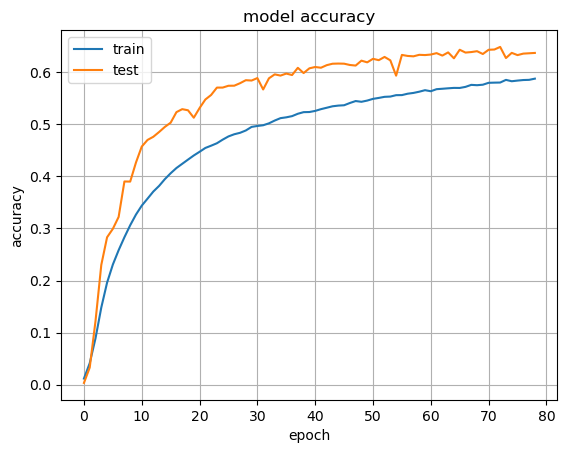

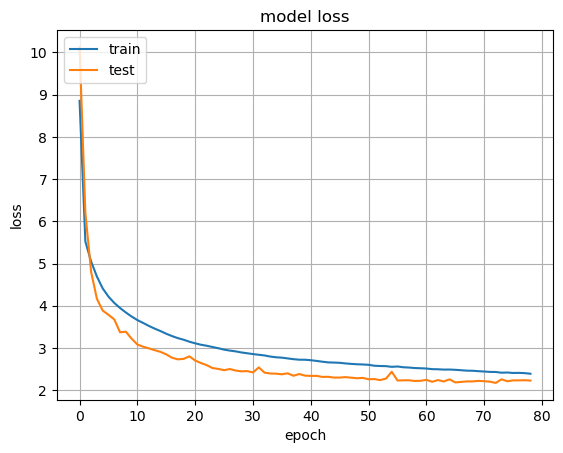

In [20]:
# history = model.fit(tr_x, tr_Y,batch_size=200,epochs=200
#           ,validation_data=(tst_x,tst_Y),callbacks=callbacks)

# history = model.fit(tr_x, tr_Y,batch_size=128,epochs=30
#           ,validation_data=(tst_x,tst_Y))

# history = model.fit(
#     x=aug.flow(tr_x, tr_Y, batch_size=batch_size),
#     validation_data=(tst_x,tst_Y),
#     epochs=30,
#     callbacks=callbacks)

history = model.fit(
    x=aug.flow(tr_x, tr_Y, batch_size=batch_size),
    validation_data=(tst_x,tst_Y),
    epochs=200,
    callbacks=callbacks)

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()


# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()


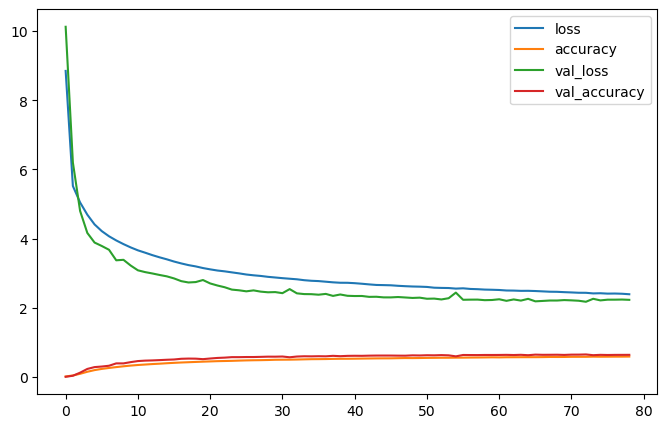

In [21]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [22]:
gc.collect()

13151

# 6. Saving model 

In [23]:
from tensorflow.keras.models import save_model
save_model(model,"CNN.h5")

# 7. Testing the model

In [24]:
test = pd.read_csv('../input/quickdraw-doodle-recognition/test_simplified.csv', index_col="key_id" ,nrows=100)
ids = test.index
imagebag = bag.from_sequence(test.drawing.values).map(drawStrokes)
test_simplified = np.array(imagebag.compute())
test_simplified = test_simplified.reshape(len(test_simplified), 32, 32, 3)

In [25]:
del imagebag
gc.collect()

21

In [26]:
prediction = model.predict(test_simplified)
indexOfBigProbability = (-prediction).argsort()[:,:4]

4/4 [==============================] - 2s 50ms/step


In [27]:
gc.collect()

1304

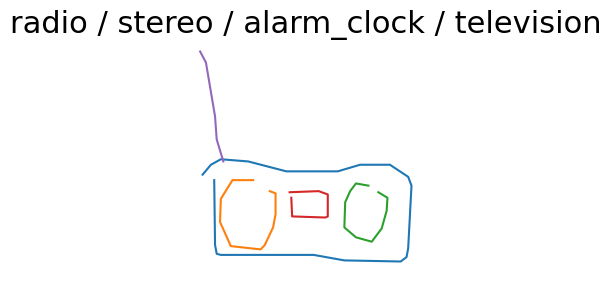

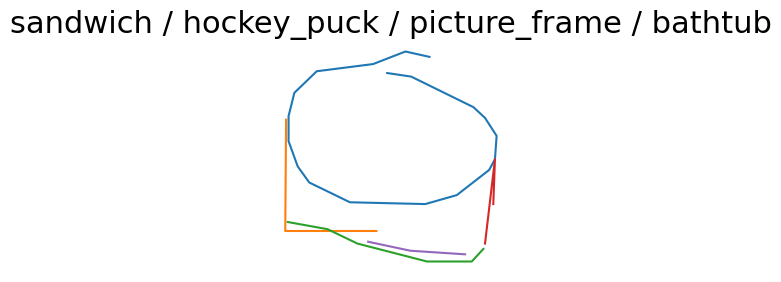

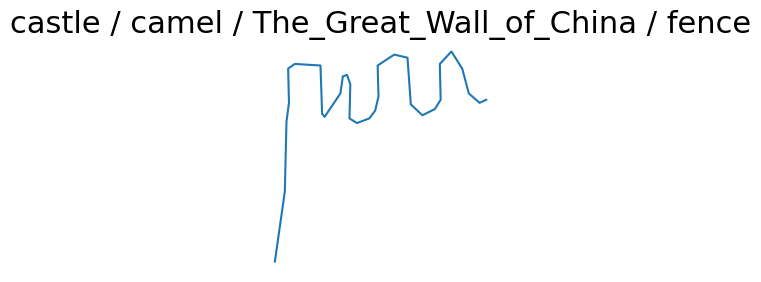

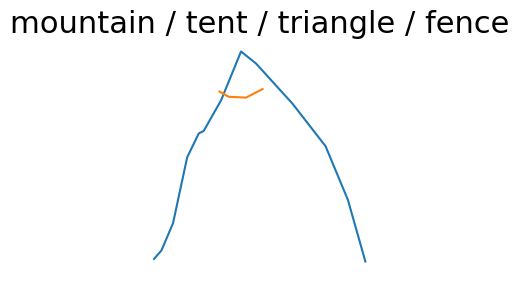

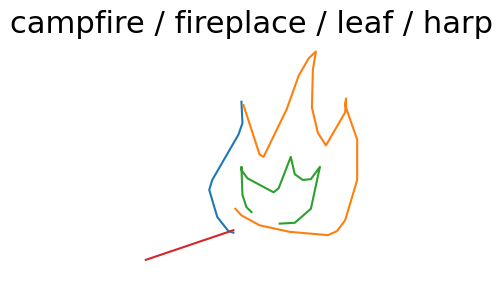

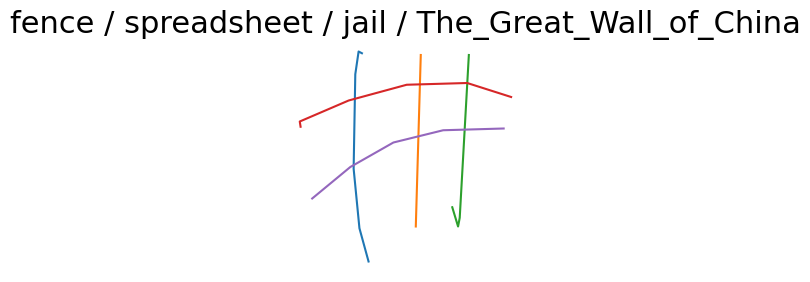

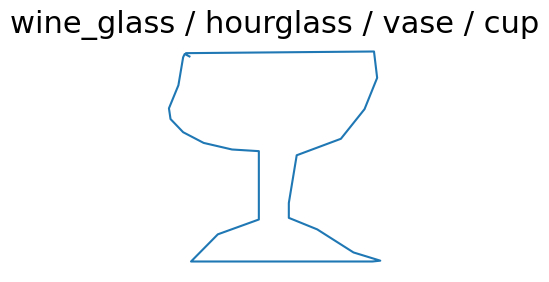

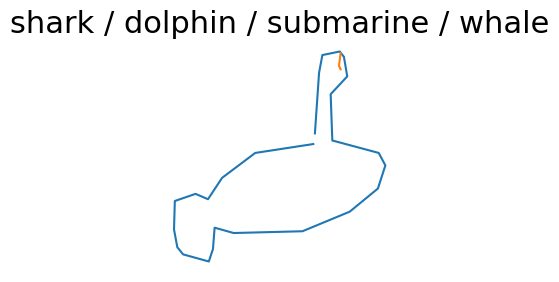

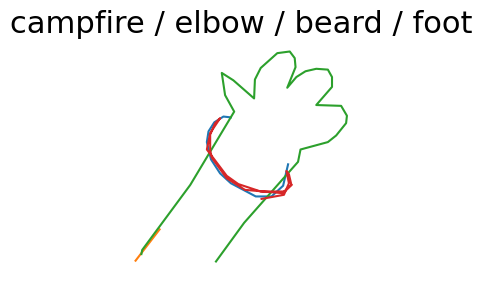

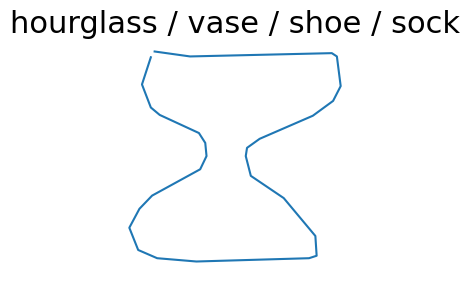

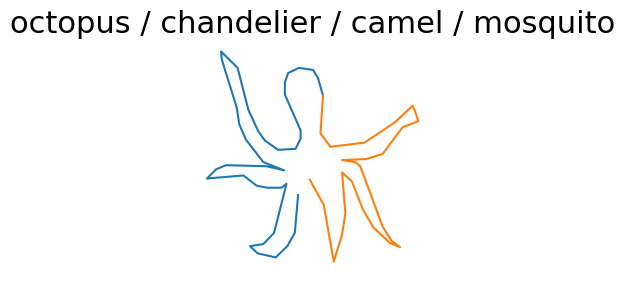

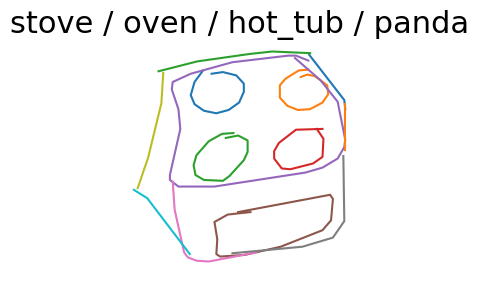

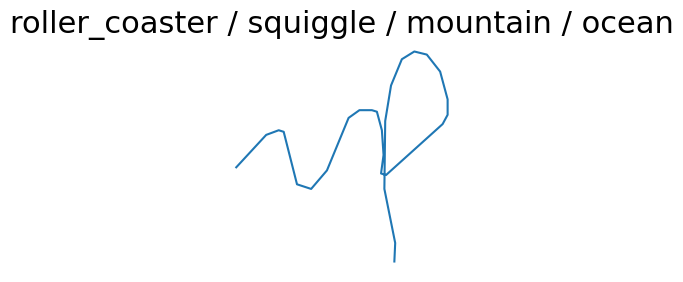

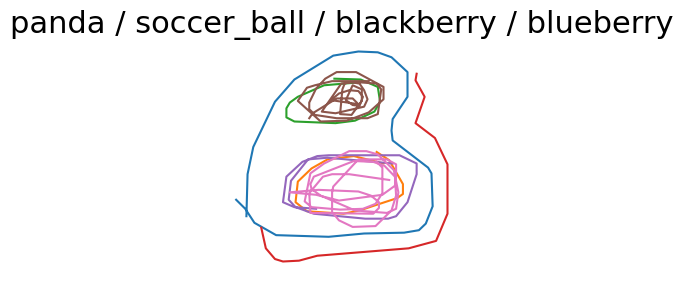

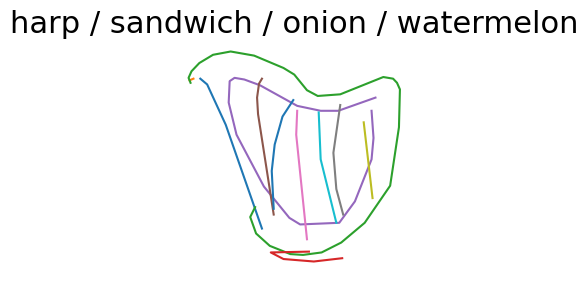

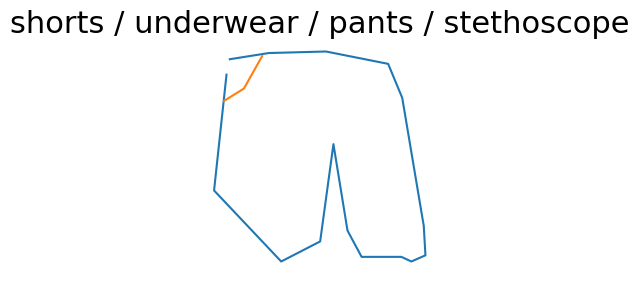

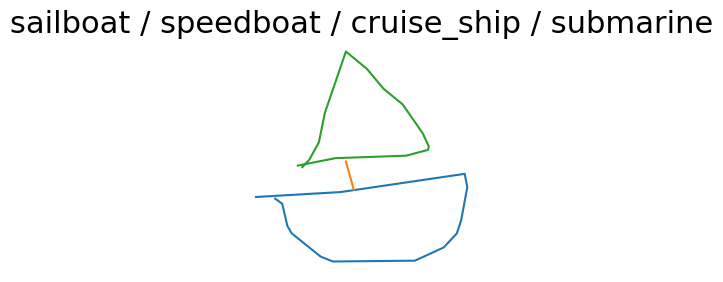

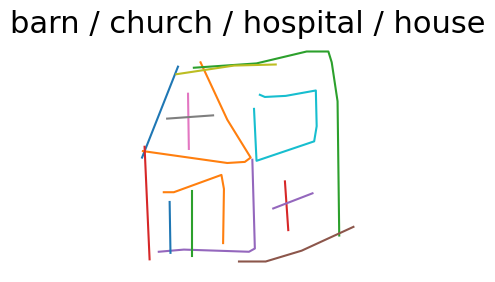

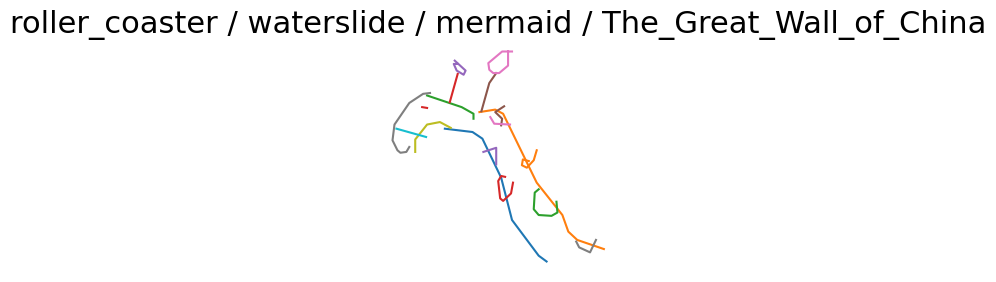

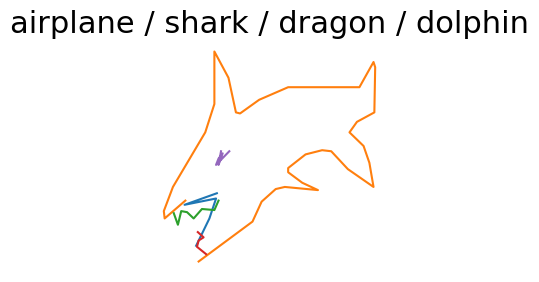

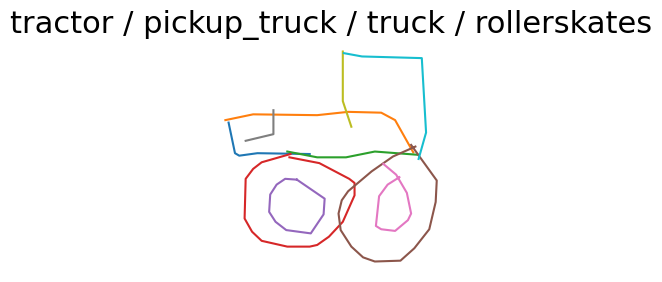

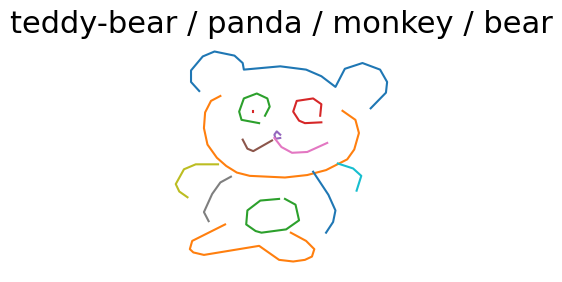

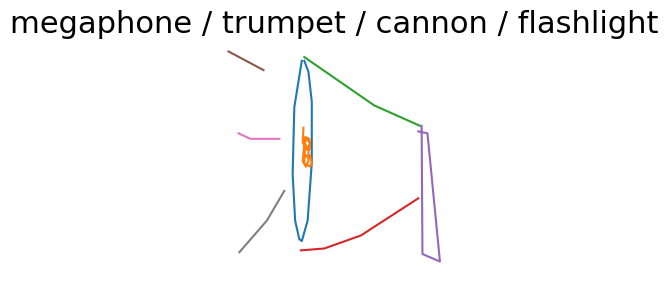

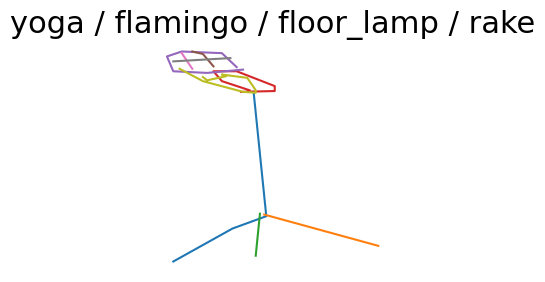

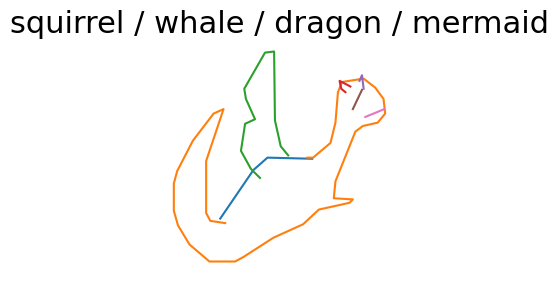

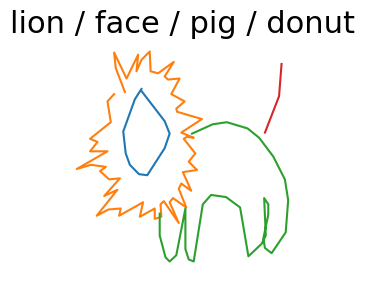

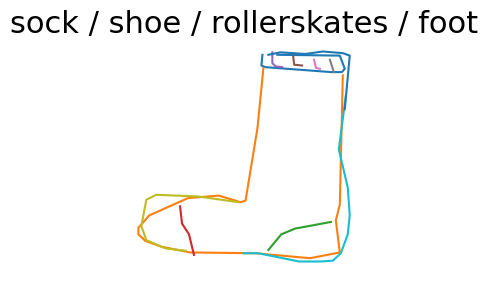

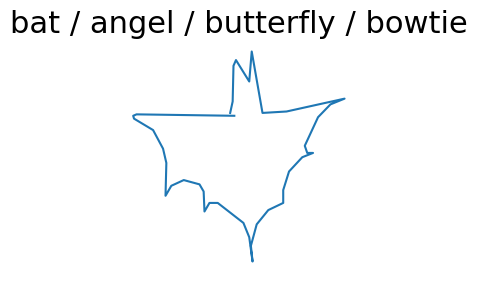

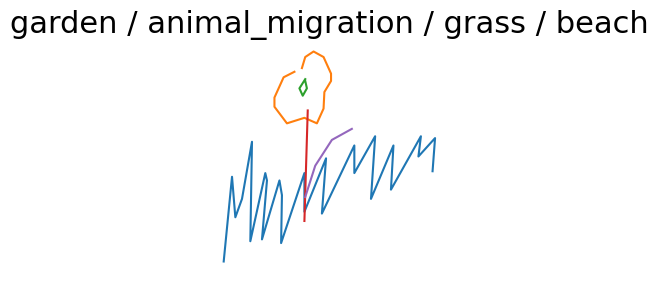

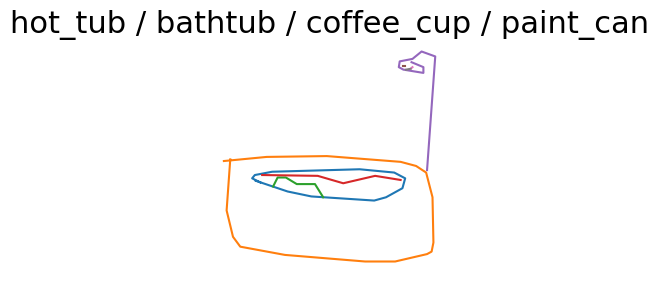

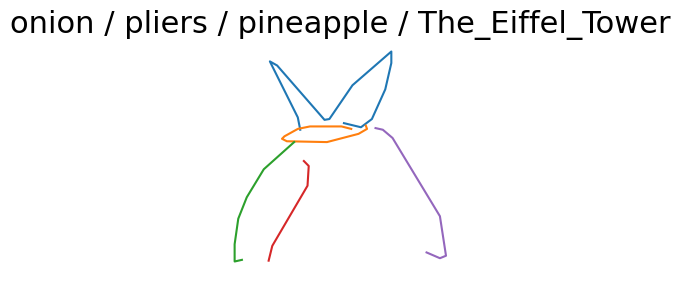

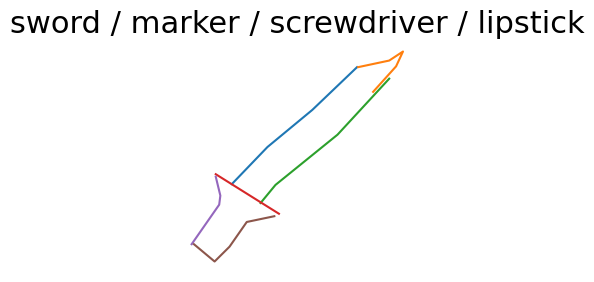

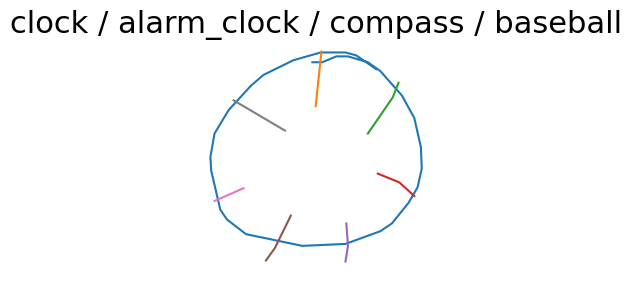

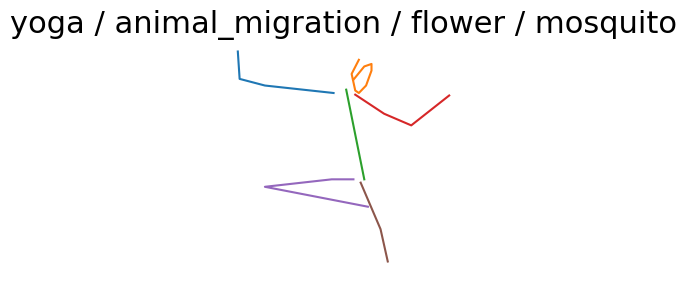

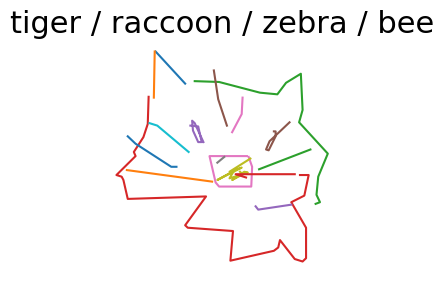

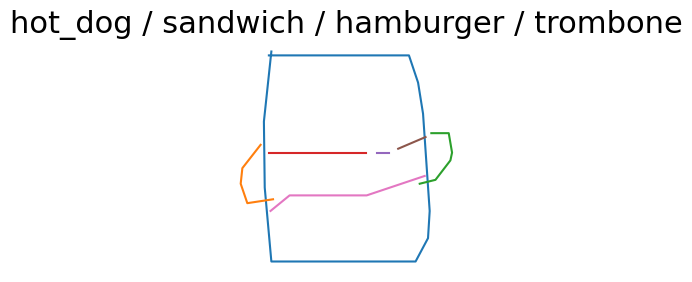

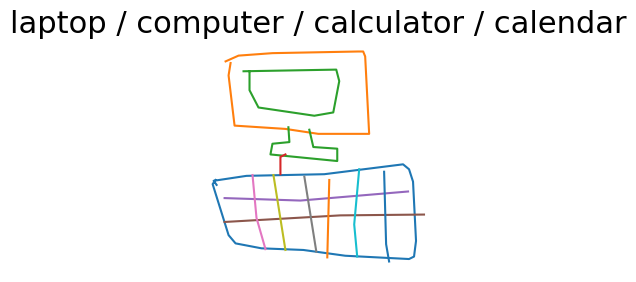

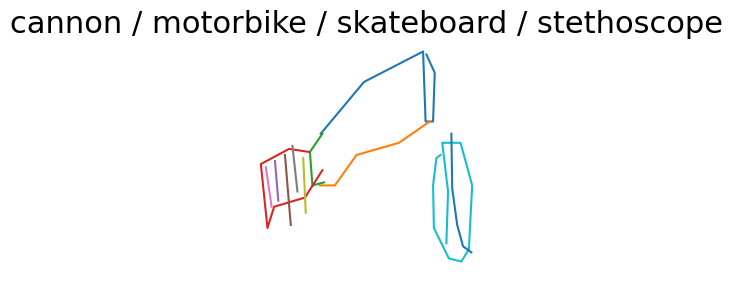

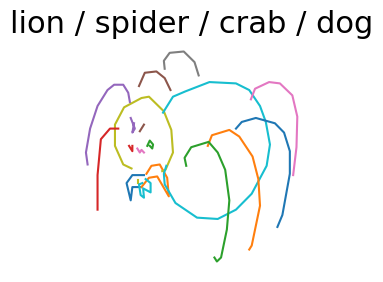

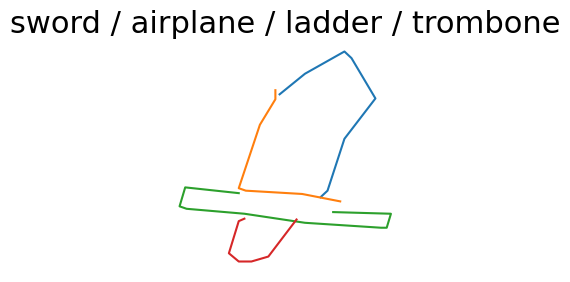

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
import ast
import warnings
warnings.filterwarnings('ignore')

raw_images = [ast.literal_eval(lst) for lst in test.loc[test.iloc[:40].index, 'drawing'].values]

j=0

for index, raw_drawing in enumerate(raw_images):
    plt.figure(figsize=(3,3));
    for x,y in raw_drawing:
        title_obj=plt.title(Y.columns[indexOfBigProbability][j][0]
                  +" / "
                 +Y.columns[indexOfBigProbability][j][1]
                  +" / "
                 +Y.columns[indexOfBigProbability][j][2]
                  +" / "
                 +Y.columns[indexOfBigProbability][j][3], fontsize=22)
        plt.subplot(1, 1, 1);
        plt.plot(x,y);
        plt.axis('off');
    plt.gca().invert_yaxis();
    j+=1;

# Training Documentation

## model with regularization
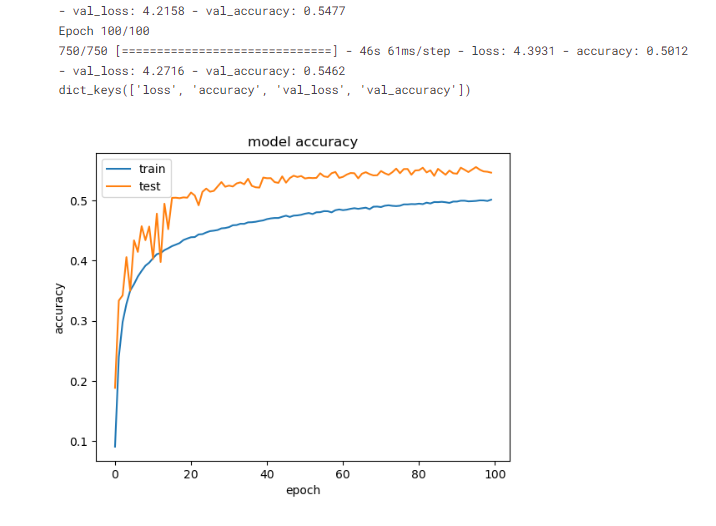

## model with data augmentation
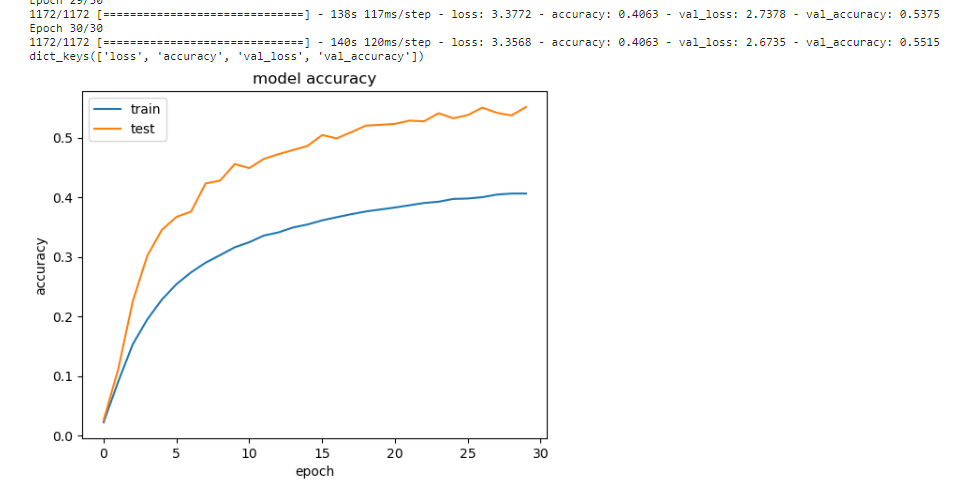

## complex model with data aug.
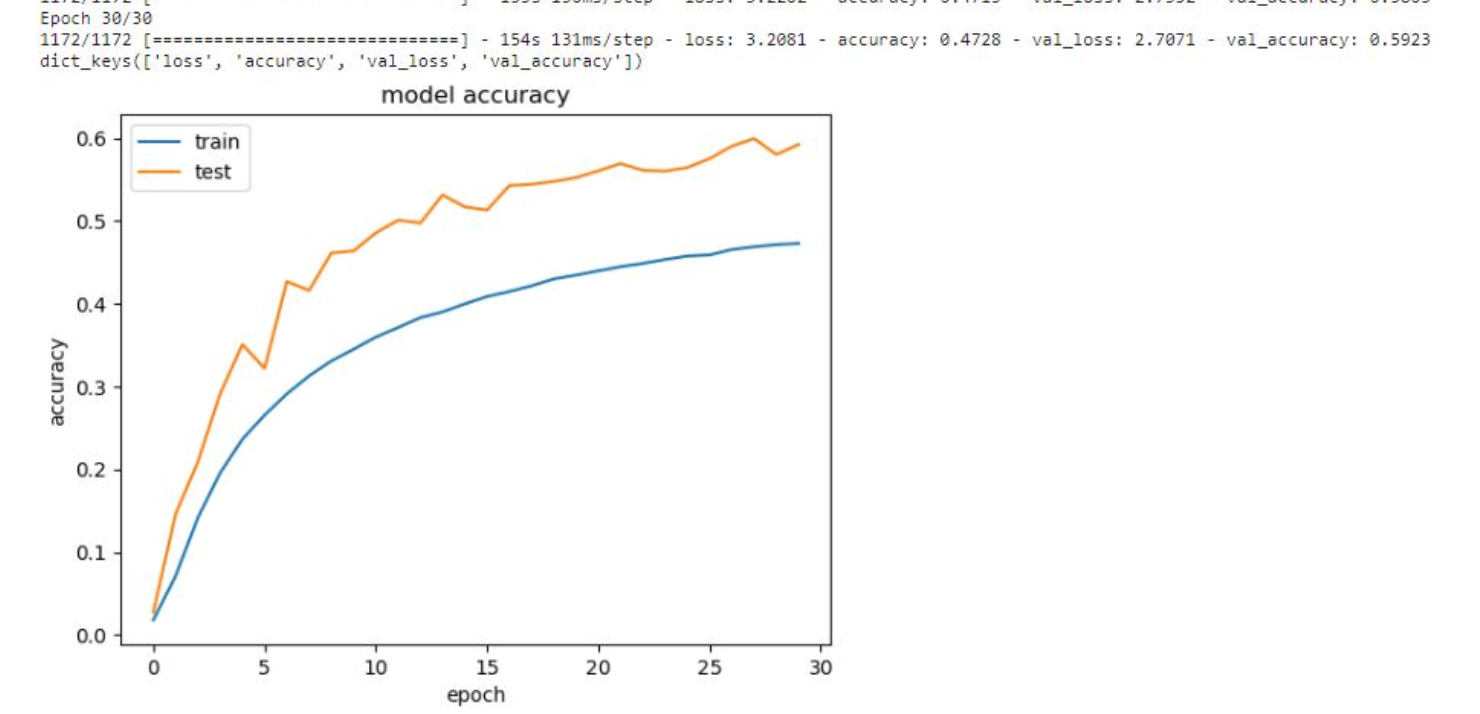

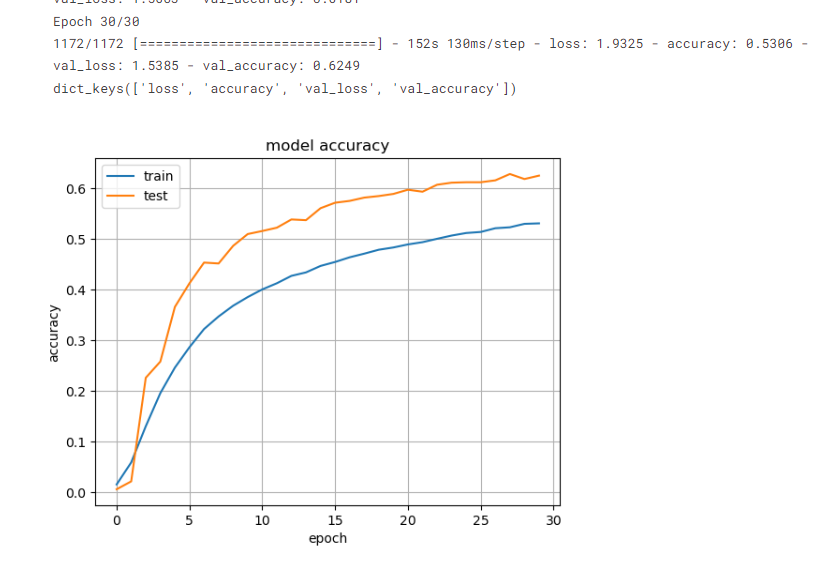

## 4 Dense Layers 
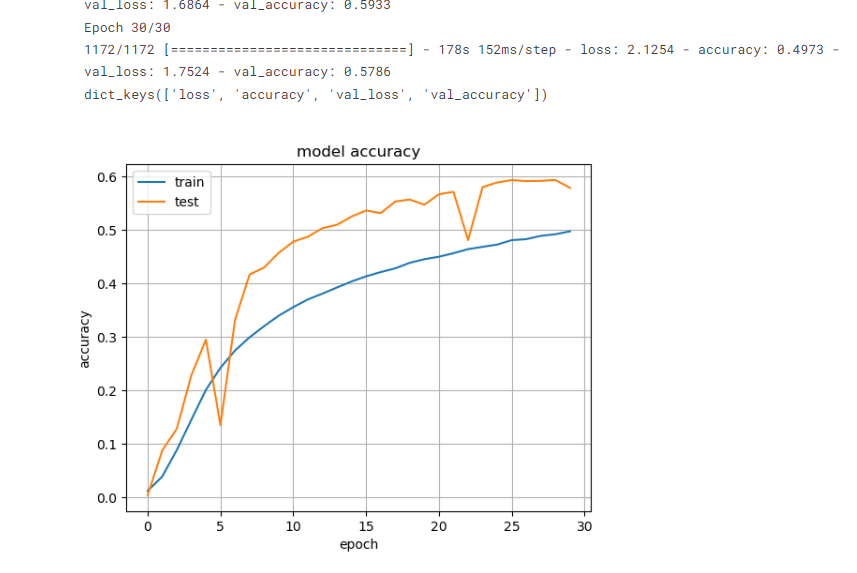

# Session hardware status :
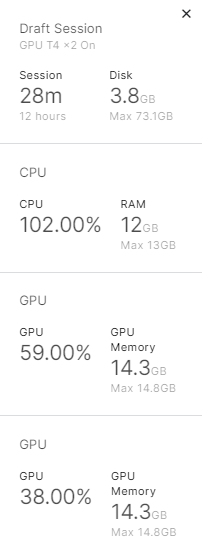